Load necessary libraries.

In [7]:
### Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

### ML packages
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import umap
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

### Msc
import warnings

### OOP Code
from ml_utils import GaussianMixtureEM

Load dataset.

In [8]:
df = pd.read_csv('00_authors.csv').rename(columns={'Unnamed: 0': 'Author'}).drop(columns='BookID')
authors = df['Author'].values  # n_samples-length array
X = df.drop(columns=['Author'])

# UMAP dimensionality reduction
warnings.filterwarnings("ignore", category=UserWarning, module="umap")  # suppress joblib warning
umap_model = umap.UMAP(n_neighbors=10, min_dist=0.3, random_state=42)
X_umap = pd.DataFrame(umap_model.fit_transform(X))

**EM Algorithm for Multivariate Gaussian Mixture Model**

Let the density of $x \in \mathbb{R}^d$ be: $p(x) = \sum_{k=1}^{K} \pi_k \cdot \mathcal{N}(x \mid \mu_k, \Sigma_k)$

where:
- $\pi_k$ are the mixing proportions (with $\sum_k \pi_k = 1$),
- $\mu_k \in \mathbb{R}^d$ is the mean of component $k$,
- $\Sigma_k \in \mathbb{R}^{d \times d}$ is the covariance matrix.

**E-step**

$\gamma_{ik} = \frac{ \pi_k \cdot \mathcal{N}(x_i \mid \mu_k, \Sigma_k) }{ \sum_{j=1}^{K} \pi_j \cdot \mathcal{N}(x_i \mid \mu_j, \Sigma_j) }$ where $\mathcal{N}(x \mid \mu, \Sigma)$ is the multivariate Gaussian density: $\mathcal{N}(x \mid \mu, \Sigma) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right)$

**M-step**

Effective number of points (soft cluster count): $N_k = \sum_{i=1}^{N} \gamma_{ik}$

Update mean: $\mu_k = \frac{1}{N_k} \sum_{i=1}^{N} \gamma_{ik} x_i$

Update covariance: $\Sigma_k = \frac{1}{N_k} \sum_{i=1}^{N} \gamma_{ik} (x_i - \mu_k)(x_i - \mu_k)^T$

Update mixing weights: $\pi_k = \frac{N_k}{N}$

Repeat E-step and M-step until convergence (e.g., change in log-likelihood is below a threshold).


In [9]:
# code in -> ml_utils.py 
# code also pasted at appendix
model = GaussianMixtureEM(K=4, num_iterations=50, allow_singular=False)
results = model.fit_fast(X_umap)

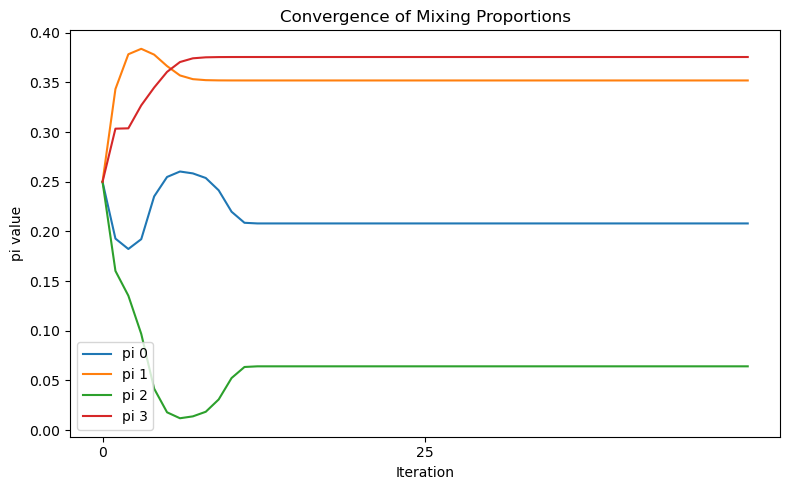

In [10]:
pis_dict = results['pis_dict']
iterations = [key for key in pis_dict if key.startswith('Iteration_')]
iterations_sorted = sorted(iterations, key=lambda x: int(x.split('_')[1]))

pi_matrix = np.array([pis_dict['Initial'][0]] + [pis_dict[it][0] for it in iterations_sorted])

plt.figure(figsize=(8, 5))
for k in range(pi_matrix.shape[1]):
    plt.plot(range(len(pi_matrix)), pi_matrix[:, k], label=f'pi {k}')

plt.title('Convergence of Mixing Proportions')
plt.xlabel('Iteration')
plt.ylabel('pi value')

steps = 25
plt.xticks(range(0, len(iterations_sorted), steps))

plt.legend()
plt.tight_layout()
plt.show()

# Compare

Now to compare my manually EM function to the built in Sklearn package!

In [11]:
sk_model = GaussianMixture(n_components=4, random_state=42)
sk_model.fit(X_umap)

# Your final results
my_pi = results['pis_dict'][f'Iteration_{model.num_iterations - 1}'][0]
my_mu = np.array(results['means'])
my_cov = np.array(results['cov'])

# Sklearn results
sk_pi = sk_model.weights_
sk_mu = sk_model.means_
sk_cov = sk_model.covariances_

Matching components based on mean proximity:
Component 0 → Sklearn 3 | Distance: 0.0000
Component 1 → Sklearn 2 | Distance: 0.0001
Component 2 → Sklearn 1 | Distance: 0.0000
Component 3 → Sklearn 0 | Distance: 0.0000

Mixing weights comparison:
Component 0: mine=0.2081 | sklearn=0.2081
Component 1: mine=0.3520 | sklearn=0.3520
Component 2: mine=0.0642 | sklearn=0.0642
Component 3: mine=0.3757 | sklearn=0.3757

Mean vector L2 distances:
Component 0: ||μ_mine - μ_sklearn|| = 0.0000
Component 1: ||μ_mine - μ_sklearn|| = 0.0001
Component 2: ||μ_mine - μ_sklearn|| = 0.0000
Component 3: ||μ_mine - μ_sklearn|| = 0.0000

Adjusted Rand Index: 1.0000


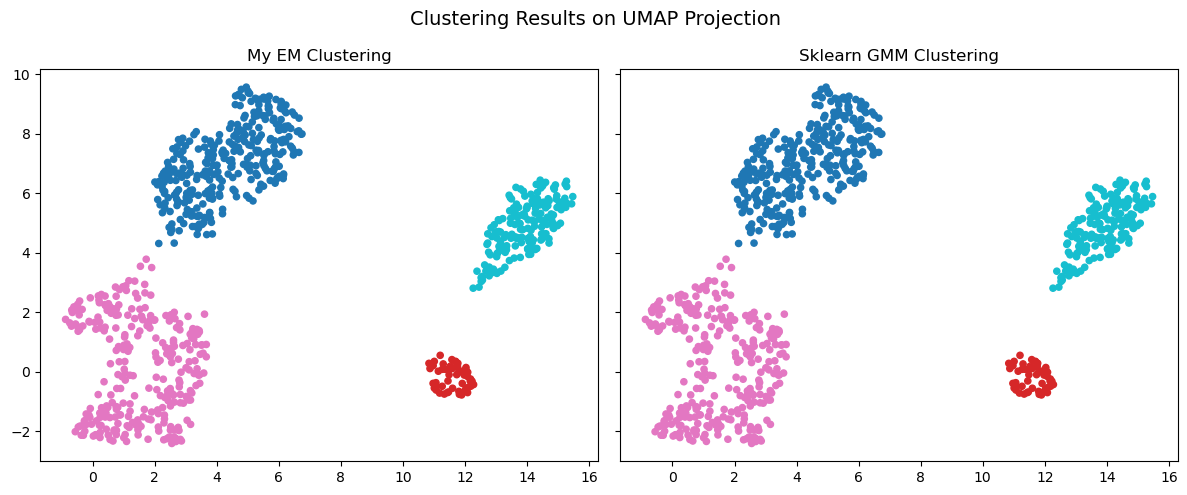

In [12]:
dist_matrix = cdist(my_mu, sk_mu)
matches = np.argmin(dist_matrix, axis=1)

print("Matching components based on mean proximity:")
for i, j in enumerate(matches):
    print(f"Component {i} → Sklearn {j} | Distance: {dist_matrix[i, j]:.4f}")

print("\nMixing weights comparison:")
for i, j in enumerate(matches):
    print(f"Component {i}: mine={my_pi[i]:.4f} | sklearn={sk_pi[j]:.4f}")

print("\nMean vector L2 distances:")
for i, j in enumerate(matches):
    delta = np.linalg.norm(my_mu[i] - sk_mu[j])
    print(f"Component {i}: ||μ_mine - μ_sklearn|| = {delta:.4f}")

my_labels = np.argmax(results['gamma'], axis=1)
sk_labels = sk_model.predict(X_umap)
ari = adjusted_rand_score(my_labels, sk_labels)

print(f"\nAdjusted Rand Index: {ari:.4f}")

remapped_labels = np.zeros_like(my_labels)
for i, j in enumerate(matches):
    remapped_labels[my_labels == i] = j

X_umap_np = X_umap.to_numpy() if isinstance(X_umap, pd.DataFrame) else X_umap

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

axs[0].scatter(X_umap_np[:, 0], X_umap_np[:, 1], c=remapped_labels, cmap='tab10', s=20)
axs[0].set_title("My EM Clustering")

axs[1].scatter(X_umap_np[:, 0], X_umap_np[:, 1], c=sk_labels, cmap='tab10', s=20)
axs[1].set_title("Sklearn GMM Clustering")

plt.suptitle("Clustering Results on UMAP Projection", fontsize=14)
plt.tight_layout()
plt.show()


Perfect matchup as sklearns package as we make iterations of our EM algorithm sufficiently large!